In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

# Lab 4: Putting it all together in a mini project

**This lab is an optional group lab.** You can choose to work alone of in a group of up to four students. You are in charge of how you want to work and who you want to work with. Maybe you really want to go through all the steps of the ML process yourself or maybe you want to practice your collaboration skills, it is up to you! Just remember to indicate who your group members are (if any) when you submit on Gradescope. If you choose to work in a group, you only need to use one of your GitHub repos.

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## Submission instructions
rubric={mechanics}

<p>You receive marks for submitting your lab correctly, please follow these instructions:</p>

<ul>
  <li><a href="https://ubc-mds.github.io/resources_pages/general_lab_instructions/">
      Follow the general lab instructions.</a></li>
  <li><a href="https://github.com/UBC-MDS/public/tree/master/rubric">
      Click here to view a description of the rubrics used to grade the questions</a></li>
  <li>Make at least three commits.</li>
  <li>Push your <code>.ipynb</code> file to your GitHub repository for this lab and upload it to Gradescope.</li>
    <ul>
      <li>Before submitting, make sure you restart the kernel and rerun all cells.</li>
    </ul>
  <li>Also upload a <code>.pdf</code> export of the notebook to facilitate grading of manual questions (preferably WebPDF, you can select two files when uploading to gradescope)</li>
  <li>Don't change any variable names that are given to you, don't move cells around, and don't include any code to install packages in the notebook.</li>
  <li>The data you download for this lab <b>SHOULD NOT BE PUSHED TO YOUR REPOSITORY</b> (there is also a <code>.gitignore</code> in the repo to prevent this).</li>
  <li>Include a clickable link to your GitHub repo for the lab just below this cell
    <ul>
      <li>It should look something like this https://github.ubc.ca/MDS-2020-21/DSCI_531_labX_yourcwl.</li>
    </ul>
  </li>
</ul>
</div>

_Points:_ 2

https://github.ubc.ca/MDS-2022-23/DSCI_573_lab4_rdhill13

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. Since this mini-project is open-ended there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you instead do a bunch of sane things and you have clearly motivated your choices, but still get lower model performance than your friend, don't sweat it.


#### A final note
Finally, the style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "several hours" but not "many hours" is a good guideline for a high quality submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and we hope you enjoy it as well. 

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
rubric={reasoning}

In this mini project, you will pick one of the following problems: 

1. A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

2. A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)
    
</div>

_Points:_ 3

The problem here is to be able to predict, based on certain characteristics (features), if a person who has taken a loan, will default on the loan or not in the next month. Therefore our target variable here is`default.payment.next.month`. We rename this column to simply call it `default`. The values under this column are 0 for no default and 1 for default. The characteristics available to us to predict whether a person will default or not include their age, gender, education and payment history over the past few months. Based on intuition, the person's payment history should be extremely crucial in making predictions but we will assess if this is true by building different machine learning models and checking the importances of the features

In [2]:
# Imports
import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [79]:
cc_df = pd.read_csv('data/UCI_Credit_Card.csv').rename(columns = {"default.payment.next.month":"default"})
cc_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


Upon looking at the dataset in Excel, we noticed there are some individuals with no bill amount and no payment amount i.e all BILL_AMT and PAY_AMT are 0 but still the individuals are being classified as defaulters. We decided to drop these rows.

In [80]:
cc_df = cc_df[(cc_df['BILL_AMT1']!=0) & (cc_df['BILL_AMT2']!=0) & (cc_df['BILL_AMT3']!=0) 
     & (cc_df['BILL_AMT4']!=0) & (cc_df['BILL_AMT5']!=0) & (cc_df['BILL_AMT6']!=0)] 
cc_df.shape

(23887, 25)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 2. Data splitting <a name="2"></a>
rubric={reasoning}

**Your tasks:**

1. Split the data into train and test portions.

> Make the decision on the `test_size` based on the capacity of your laptop. 
    
</div>

_Points:_ 1

In [81]:
train_df, test_df = train_test_split(cc_df, test_size=0.20, random_state=123)

In [82]:
train_df.shape

(19109, 25)

In [83]:
test_df.shape

(4778, 25)

##### Further splitting into X_train, y_train, X_test and y_test is done below

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 3. EDA <a name="3"></a>
rubric={viz,reasoning}
    
Perform exploratory data analysis on the train set.

**Your tasks:**

1. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
2. Summarize your initial observations about the data. 
3. Pick appropriate metric/metrics for assessment. 
    
</div>

_Points:_ 6

- Our positive class is 1 under the "default" column.
- We have class imbalance since approximately 22% of the examples are defaulting while 78% are not defaulting. 
- We see that "EDUCATION" has 7 unique categories to it whereas the data dictionary says there should be 6 categories. There is an extra category "0". Categories 5 and 6 both mean "Unknown" and there is an extra category 0. Since there aren't many observation under 0,5 and 6 ,  we have combined all 3 of these categories under "others" i.e. 4 
- Similarly we see an extra category 0 in MARRIAGE which we have included under "others" i.e 3 since there aren't many observations under class 0 

- We also noticed that there are some observations in all the "PAY_" columns with values of -2 which are not defined in the data dictionary. For our project we assume these values are synonymous with -1 or maybe even better.

- The "BILL_AMT" columns also have negative values which is strange but could mean that the credit card bill is negative because the individual paid more than their bill before the bill was generated

- There  seems to be a high correlation between consecutive PAY_ columns like PAY_2 and PAY_3 etc as well as between consecutive BILL_AMT cols

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19109 entries, 22629 to 25112
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         19109 non-null  int64  
 1   LIMIT_BAL  19109 non-null  float64
 2   SEX        19109 non-null  int64  
 3   EDUCATION  19109 non-null  int64  
 4   MARRIAGE   19109 non-null  int64  
 5   AGE        19109 non-null  int64  
 6   PAY_0      19109 non-null  int64  
 7   PAY_2      19109 non-null  int64  
 8   PAY_3      19109 non-null  int64  
 9   PAY_4      19109 non-null  int64  
 10  PAY_5      19109 non-null  int64  
 11  PAY_6      19109 non-null  int64  
 12  BILL_AMT1  19109 non-null  float64
 13  BILL_AMT2  19109 non-null  float64
 14  BILL_AMT3  19109 non-null  float64
 15  BILL_AMT4  19109 non-null  float64
 16  BILL_AMT5  19109 non-null  float64
 17  BILL_AMT6  19109 non-null  float64
 18  PAY_AMT1   19109 non-null  float64
 19  PAY_AMT2   19109 non-null  float64
 20  PA

In [9]:
train_df.nunique()

ID           19109
LIMIT_BAL       81
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             55
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    16774
BILL_AMT2    16733
BILL_AMT3    16668
BILL_AMT4    16518
BILL_AMT5    16296
BILL_AMT6    16133
PAY_AMT1      6228
PAY_AMT2      6160
PAY_AMT3      5967
PAY_AMT4      5548
PAY_AMT5      5577
PAY_AMT6      5487
default          2
dtype: int64

In [10]:
prop_neg = round(train_df['default'].value_counts()[0]/train_df.shape[0],2)
prop_pos = round(train_df['default'].value_counts()[1]/train_df.shape[0],2)

print (f"Proportion of positive class:{prop_pos}")
print (f"Proportion of positive class:{prop_neg}")

Proportion of positive class:0.22
Proportion of positive class:0.78


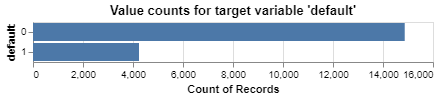

In [11]:
alt.Chart(train_df,title = "Value counts for target variable 'default'").mark_bar().encode(
    y = alt.Y("default:N"),
    x = alt.X("count()"))

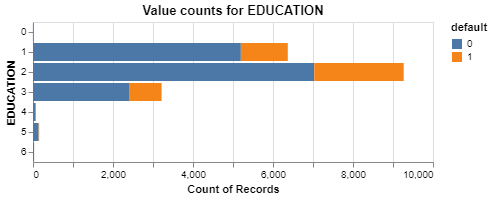

In [12]:
alt.Chart(train_df,title = "Value counts for EDUCATION").mark_bar().encode(
    y = alt.Y("EDUCATION:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

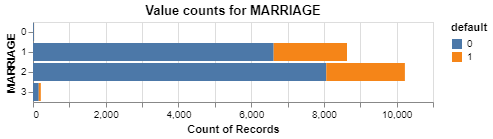

In [13]:
alt.Chart(train_df,title = "Value counts for MARRIAGE").mark_bar().encode(
    y = alt.Y("MARRIAGE:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

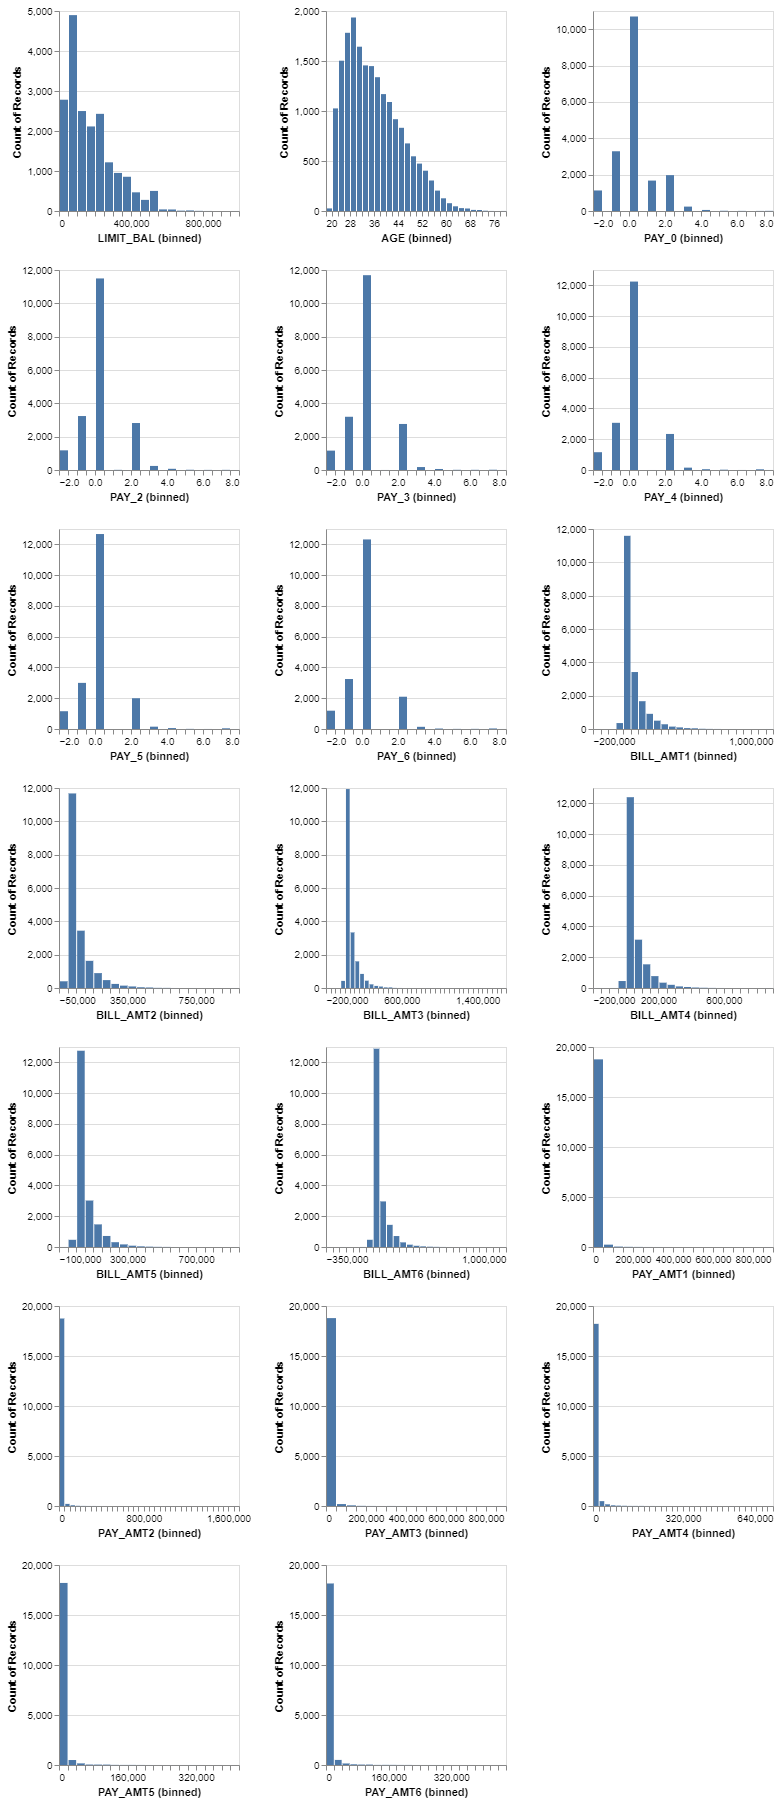

In [14]:
numeric_cols = train_df.select_dtypes(
    include=['float64', 'int64']).drop(
    columns=["ID", "SEX","default","MARRIAGE","EDUCATION"]).columns.to_list()

alt.Chart(train_df).mark_bar().encode(
     alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
     y='count()',
).properties(
    width=180,
    height=200
).repeat(
    numeric_cols,columns=3
)

In [15]:
train_df[numeric_cols].corr('kendall').style.background_gradient()


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.125464,-0.256986,-0.276609,-0.272436,-0.264727,-0.254886,-0.250814,0.162362,0.157774,0.160109,0.162296,0.159671,0.152657,0.302686,0.309603,0.311738,0.308217,0.310925,0.323990
AGE,0.125464,1.000000,-0.048208,-0.056164,-0.057069,-0.051071,-0.059394,-0.060449,0.023710,0.024597,0.024349,0.021113,0.018249,0.017749,0.043491,0.054709,0.043084,0.049699,0.046343,0.042401
PAY_0,-0.256986,-0.048208,1.000000,0.739523,0.615202,0.583570,0.554843,0.529939,0.272528,0.269259,0.259129,0.254325,0.251450,0.249135,-0.137678,-0.106509,-0.104956,-0.084952,-0.082909,-0.090844
PAY_2,-0.276609,-0.056164,0.739523,1.000000,0.736816,0.658295,0.625853,0.588139,0.314972,0.306419,0.291184,0.284166,0.279399,0.277510,-0.172881,-0.103880,-0.097504,-0.081955,-0.073713,-0.084893
PAY_3,-0.272436,-0.057069,0.615202,0.736816,1.000000,0.732783,0.648916,0.609639,0.282352,0.313995,0.300531,0.291345,0.284530,0.279485,-0.001342,-0.183601,-0.108719,-0.079721,-0.075949,-0.086126
PAY_4,-0.264727,-0.051071,0.583570,0.658295,0.732783,1.000000,0.751625,0.655264,0.278215,0.298647,0.331348,0.322008,0.309105,0.301801,-0.033090,0.002741,-0.186841,-0.091918,-0.067554,-0.070847
PAY_5,-0.254886,-0.059394,0.554843,0.625853,0.648916,0.751625,1.000000,0.742851,0.272954,0.292132,0.316183,0.355056,0.341491,0.326040,-0.040310,-0.023020,-0.008381,-0.169143,-0.073045,-0.064135
PAY_6,-0.250814,-0.060449,0.529939,0.588139,0.609639,0.655264,0.742851,1.000000,0.270539,0.288090,0.304489,0.331411,0.370498,0.356286,-0.031474,-0.038540,-0.024638,0.004588,-0.155245,-0.067675
BILL_AMT1,0.162362,0.023710,0.272528,0.314972,0.282352,0.278215,0.272954,0.270539,1.000000,0.842179,0.767765,0.699374,0.651774,0.617241,0.343822,0.320703,0.290214,0.291883,0.274728,0.267644
BILL_AMT2,0.157774,0.024597,0.269259,0.306419,0.313995,0.298647,0.292132,0.288090,0.842179,1.000000,0.828753,0.743113,0.684884,0.647882,0.424398,0.330795,0.299453,0.297366,0.286196,0.276686


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 4. Feature engineering (Challenging)
rubric={reasoning}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing.
    
</div>

_Points:_ 0.5

In [16]:
# - Our main engineered feature is the sum of the pay statuses:
#    - If 0 or below, means that individual does not owe any money. 
#    - If above 0, means the individual does owe money; in other words, he's behind some payments. The higher the value in this column, the longer the individual has gone without repaying a loan


- Our main engineered feature is the max of the pay statuses:
   - This feature will help us tell the longest the individual has gone without paying a bill throughout their credit payment history as depicted in the dataset . A larger value would indicate an individual did not pay the bill for a long time. The reason for choosing 'max' of these values is that, even if an individual pays most of the bills on time such that all of the PAY_ columns for that individual have 0s but 1 column has a value of 6, then the bank would want to pay attention to that individual
   - We have also created 2 additional columns -> sum of all BILL_AMT columns which gives us the total amount due for an individual and sum of all PAY_AMT columns which tells us the total amount that the individual has repaid.


Other possible stuff :
    
    - (pay_amt*/bill_amt{*+1})/num cols instead of total bill/total paid. This is probably more useful.
    - we can do count of pending payments (positive values of pay columns) instead of sum.

In [84]:
# creating total_pay
train_df = train_df.assign(longest_unpaid_streak=train_df[[
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].max(axis=1))

# creating total_bill
train_df = train_df.assign(total_bill=train_df[[
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]].sum(axis=1))

# creating total_paid
train_df = train_df.assign(total_paid=train_df[[
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]].sum(axis=1))

# recategorizing classses 0,5,6 in education as "Others"
train_df['EDUCATION'] = np.where((train_df['EDUCATION']==5) |
                                 (train_df['EDUCATION']==6 )|
                                 (train_df['EDUCATION']==0),4,
                                 train_df['EDUCATION'])

# recategorizing class 0 in marriage as "Others"
train_df['MARRIAGE'] = np.where(train_df['MARRIAGE']==0 ,3,
                                 train_df['MARRIAGE'])

### carrying out all changes above on test data as well
test_df = test_df.assign(longest_unpaid_streak=test_df[[
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].max(axis=1))

test_df = test_df.assign(total_bill=test_df[[
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]].sum(axis=1))

test_df = test_df.assign(total_paid=test_df[[
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]].sum(axis=1))

test_df['EDUCATION'] = np.where((test_df['EDUCATION']==5) |
                                 (test_df['EDUCATION']==6 )|
                                 (test_df['EDUCATION']==0),4,
                                 test_df['EDUCATION'])
                                
test_df['MARRIAGE'] = np.where(test_df['MARRIAGE']==0 ,3,
                                 test_df['MARRIAGE'])                                


In [87]:
## creating x_train,_train, x_test and y_test
X_train = train_df.drop(columns='default')
y_train = train_df['default']
X_test = test_df.drop(columns='default')
y_test = test_df['default']

# X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(
#     X_train, y_train, test_size=0.10, random_state=123
# )

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 5. Preprocessing and transformations <a name="5"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 
    
</div>

_Points:_ 4

- We  drop ID which is an identifier column and SEX because we do not want to consider gender as a differentiator between people who default and don't default
- We treat EDUCATION as an ordinal feature and MARRIAGE as a categorical feature.

In [19]:
drop_features = ['ID', 'SEX']
#numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
numeric_features = ['LIMIT_BAL', 'AGE','longest_unpaid_streak',
                   'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                    'total_bill', 'total_paid']
ordinal_features = ['EDUCATION']
categorical_features = ['MARRIAGE']

ordinal_levels = [1,2,3,4]


preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(categories=[ordinal_levels]),ordinal_features),
    (OneHotEncoder(sparse=False,handle_unknown='ignore'),categorical_features),
    ("drop", drop_features)   
)

preprocessor_ensemble = make_column_transformer(
    (OrdinalEncoder(categories=[ordinal_levels]),ordinal_features),
    ("drop", drop_features)  
)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 6. Baseline model <a name="6"></a>
rubric={accuracy}

**Your tasks:**
1. Train a baseline model for your task and report its performance.
    
</div>

_Points:_ 2

In [20]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

classification_metrics = ["accuracy", "precision", "recall", "f1"]
dc = DummyClassifier()
cross_val_results = {}
cross_val_results['dummy'] = (pd.DataFrame(cross_validate(dc,
                                                         X_train,
                                                         y_train,
                                                         return_train_score=True,
                                                         scoring=classification_metrics))
                              .agg(['mean', 'std']).round(3).T)

# Show the train and validation scores
cross_val_results['dummy']

,mean,std
fit_time,0.003,0.001
score_time,0.005,0.002
test_accuracy,0.778,0.000
train_accuracy,0.778,0.000
test_precision,0.000,0.000
train_precision,0.000,0.000
test_recall,0.000,0.000
train_recall,0.000,0.000
test_f1,0.000,0.000
train_f1,0.000,0.000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 7. Linear models <a name="7"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.
    
</div>

_Points:_ 8

Since our concern is to predict if an individual will default on a loan or not, we will consider F1 as our metric of choice as we want to capture both precision and recall. High false positives would mean predicting that an individual will default when in actuality they wont. In this case, the bank may end up spending resources and being strict with non-defaults and could end up losing valuable customers. On the other hand high false negatives would mean not identifying individuals who would default which would result in monetary loss to the bank. Hence since we want to minimize both false positives and false negatives, we will use F1 scoere as our metric. The validation F1 score is 54.7%  and extremely close the the training F1 (54.6%) which means our model is not overfitting. Further, our logistic regression model automatically deals with the class imbalance by choosing class_weight= 'balanced' during hyperparameter optimization. However will try to  get better scores by using other models


In [21]:
from scipy.stats import lognorm, loguniform, randint

pipe_logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123,
                                                        max_iter=1000))


param_dist_logreg = {
    "logisticregression__class_weight": [None, 'balanced'],
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_dist_logreg,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring=classification_metrics,
    refit = 'f1'
)
random_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'longest_unpaid_streak',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5'...
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=123))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000122FD264550>,
                                        'logisticregression__class_weight': [None,
                                                                             'balanced']},
                   random_state=123, refit='f1', return_train_score=True,
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

In [22]:
cross_val_results['logreg'] = pd.DataFrame(cross_validate(random_search_logreg.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg']

,mean,std
fit_time,0.052,0.004
score_time,0.009,0.001
test_accuracy,0.760,0.005
train_accuracy,0.760,0.001
test_precision,0.470,0.008
train_precision,0.471,0.002
test_recall,0.651,0.009
train_recall,0.653,0.003
test_f1,0.546,0.007
train_f1,0.547,0.002


In [23]:
random_search_logreg.best_params_

{'logisticregression__C': 0.023419595259846073,
 'logisticregression__class_weight': 'balanced'}

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 8. Different models <a name="8"></a>
rubric={accuracy,reasoning}

**Your tasks:**
1. Try out three other models aside from the linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat the performance of the linear model? 
    
</div>

_Points:_ 10

We will use the following non-models
   - Naive Bayes
   - RandomForestClassifier
   - LGBM

In [24]:
# SVC

In [25]:
# svc_bal = make_pipeline(preprocessor, SVC(class_weight="balanced", random_state=123))

# cross_val_results['svc_bal'] = pd.DataFrame(cross_validate(svc_bal,
#                                    X_train,
#                                    y_train,
#                                    return_train_score=True,
#                                    scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# # Show the train and validation scores
# cross_val_results['svc_bal'] 


# Naive Bayes

In [26]:
NB_bal = make_pipeline(preprocessor, BernoulliNB())

cross_val_results['NB_bal'] = pd.DataFrame(cross_validate(NB_bal,
                                  X_train,
                                  y_train,
                                  return_train_score=True,
                                  scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB_bal'] 




,mean,std
fit_time,0.024,0.003
score_time,0.010,0.001
test_accuracy,0.788,0.002
train_accuracy,0.787,0.001
test_precision,0.519,0.004
train_precision,0.519,0.001
test_recall,0.583,0.010
train_recall,0.583,0.004
test_f1,0.549,0.006
train_f1,0.549,0.002


# Random Forest

In [27]:
RF_bal = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_bal'] = pd.DataFrame(cross_validate(RF_bal,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_bal'] 


,mean,std
fit_time,3.101,0.059
score_time,0.065,0.001
test_accuracy,0.821,0.002
train_accuracy,1.000,0.000
test_precision,0.668,0.010
train_precision,1.000,0.000
test_recall,0.381,0.015
train_recall,1.000,0.000
test_f1,0.485,0.011
train_f1,1.000,0.000


# Light GBM

In [28]:
from lightgbm.sklearn import LGBMClassifier

LGBM_bal = LGBMClassifier(class_weight="balanced", random_state=123)  # no need to scale since trees. also better f1
cross_val_results['LGBM_bal'] = pd.DataFrame(cross_validate(LGBM_bal,
                                                            X_train.drop(columns=['SEX',"ID"]),
                                                            y_train,
                                                            return_train_score=True,
                                                            scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['LGBM_bal'] 

,mean,std
fit_time,0.136,0.012
score_time,0.010,0.001
test_accuracy,0.778,0.004
train_accuracy,0.844,0.002
test_precision,0.499,0.006
train_precision,0.615,0.004
test_recall,0.624,0.009
train_recall,0.798,0.007
test_f1,0.555,0.005
train_f1,0.695,0.004


In [29]:
combined_results = pd.concat(
cross_val_results,
axis='columns'
).xs(
'mean',
axis='columns',
level=1
).style.format(
precision=3
)
combined_results

,dummy,logreg,NB_bal,RF_bal,LGBM_bal
fit_time,0.003,0.052,0.024,3.101,0.136
score_time,0.005,0.009,0.010,0.065,0.010
test_accuracy,0.778,0.760,0.788,0.821,0.778
train_accuracy,0.778,0.760,0.787,1.000,0.844
test_precision,0.000,0.470,0.519,0.668,0.499
train_precision,0.000,0.471,0.519,1.000,0.615
test_recall,0.000,0.651,0.583,0.381,0.624
train_recall,0.000,0.653,0.583,1.000,0.798
test_f1,0.000,0.546,0.549,0.485,0.555
train_f1,0.000,0.547,0.549,1.000,0.695


Based on the results above, if we look at f1 scores, we can see that  Naive Bayes performs better than logistic regression. The validation score for logisitc regression is 54.6% whereas for Naive Byaes it is 54.9%. Random forest has a much higher training score (100% ) but a worse validation score (48.5%) than logistic regression.This huge gap between train and validation scores means that Random Forest is overfitting alot.  LGBM has the highest validation score (55.5%) but the gap between the training and validation scores is big enough to suggest overfitting (there is almost a 14% gap). 
We will try to deal with these problems using feature selection and hyperparameter optimization 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 9. Feature selection (Challenging)
rubric={reasoning}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises unless you think there are other benefits with using less features.
    
</div>

_Points:_ 0.5

We'll use RFECV to reduce the feature space, using RidgeClassifier to generate feature importance. Not going to test on LGBM as we can't use the non SKLearn models in an SKLearn pipeline.

We are starting with 27 features. Using RidgeClassifier to reduce the feature space leaves us with the 19 most important features.

Key findings: 
* Using feature selection leads to slightly worse validation scores for all our models. 
* It does not help much in reducing overfitting in either Random Forest or LGBM
* However the reduction in the scores is extremely small. But by removing 8 features, we are reducing the complexity of our model. So for each model we will use only the subset of 19 features in our model and then perform hyperparameter optimization


# Logistic Regression

In [30]:
#Baseline feature counts

pipe_logreg.fit(X_train, y_train) 
pipe_logreg.named_steps["logisticregression"].n_features_in_

27

In [31]:
# Linear Classifier

from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifier

logreg_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), LogisticRegression(class_weight="balanced",
                                                        random_state=123,
                                                        max_iter=1000))


param_dist = {
    "logisticregression__class_weight": [None, 'balanced'],
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg_RFE = RandomizedSearchCV(
    logreg_RFE,
    param_distributions=param_dist,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring=classification_metrics,
    refit = 'f1',
)
random_search_logreg_RFE.fit(X_train, y_train)

cross_val_results['logreg_RFE'] = pd.DataFrame(cross_validate(random_search_logreg_RFE.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T



In [32]:
# Linear RFE Scores
cross_val_results['logreg_RFE']

,mean,std
fit_time,1.874,0.057
score_time,0.010,0.001
test_accuracy,0.758,0.006
train_accuracy,0.758,0.004
test_precision,0.468,0.009
train_precision,0.467,0.005
test_recall,0.651,0.011
train_recall,0.653,0.005
test_f1,0.544,0.007
train_f1,0.545,0.002


In [33]:
# Resulting number of features

logreg_RFE.fit(X_train, y_train)
logreg_RFE.named_steps["logisticregression"].n_features_in_

19

In [34]:
# SVC

In [35]:
# # SVC 

# svc_bal_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), SVC(class_weight="balanced", random_state=123))

# cross_val_results['svc_bal_RFE'] = pd.DataFrame(cross_validate(svc_bal_RFE,
#                                                            X_train,
#                                                            y_train,
#                                                            return_train_score=True,
#                                                            scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [36]:
# # SVC RFE Scores
# cross_val_results['svc_bal_RFE']

In [37]:
# #SVC Baseline Scores
# cross_val_results['svc_bal']

In [38]:
# svc_bal_RFE.fit(X_train,y_train)
# svc_bal_RFE.named_steps['svc'].n_features_in_

# Naive Bayes

In [39]:
# Naive Bayes

NB_bal_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), BernoulliNB())

cross_val_results['NB_bal_RFE'] = pd.DataFrame(cross_validate(NB_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [40]:
#NB Baseline Scores
cross_val_results['NB_bal']

,mean,std
fit_time,0.024,0.003
score_time,0.010,0.001
test_accuracy,0.788,0.002
train_accuracy,0.787,0.001
test_precision,0.519,0.004
train_precision,0.519,0.001
test_recall,0.583,0.010
train_recall,0.583,0.004
test_f1,0.549,0.006
train_f1,0.549,0.002


In [41]:
# NB RFE Scores
cross_val_results['NB_bal_RFE']

,mean,std
fit_time,2.121,0.259
score_time,0.011,0.001
test_accuracy,0.794,0.006
train_accuracy,0.794,0.006
test_precision,0.535,0.014
train_precision,0.534,0.015
test_recall,0.564,0.028
train_recall,0.559,0.019
test_f1,0.548,0.013
train_f1,0.546,0.004


In [42]:
NB_bal_RFE.fit(X_train,y_train)
NB_bal_RFE.named_steps['bernoullinb'].n_features_in_

19

# Random Forest

In [43]:
# Random Forests

RF_bal_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_bal_RFE'] = pd.DataFrame(cross_validate(RF_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [44]:
# RF RFE Scores
cross_val_results['RF_bal_RFE'] 

,mean,std
fit_time,3.328,0.345
score_time,0.070,0.001
test_accuracy,0.792,0.036
train_accuracy,0.998,0.004
test_precision,0.564,0.109
train_precision,0.992,0.013
test_recall,0.399,0.023
train_recall,0.998,0.004
test_f1,0.462,0.032
train_f1,0.995,0.009


In [45]:
#RF Baseline Scores
cross_val_results['RF_bal'] 

,mean,std
fit_time,3.101,0.059
score_time,0.065,0.001
test_accuracy,0.821,0.002
train_accuracy,1.000,0.000
test_precision,0.668,0.010
train_precision,1.000,0.000
test_recall,0.381,0.015
train_recall,1.000,0.000
test_f1,0.485,0.011
train_f1,1.000,0.000


In [46]:
RF_bal_RFE.fit(X_train,y_train)
RF_bal_RFE.named_steps['randomforestclassifier'].n_features_in_

19

# LGBM

In [47]:

LGBM_bal_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), 
                           LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_bal_RFE'] = pd.DataFrame(cross_validate(LGBM_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [48]:
cross_val_results['LGBM_bal_RFE']

,mean,std
fit_time,2.082,0.073
score_time,0.019,0.002
test_accuracy,0.773,0.005
train_accuracy,0.809,0.016
test_precision,0.491,0.009
train_precision,0.554,0.027
test_recall,0.633,0.012
train_recall,0.723,0.038
test_f1,0.553,0.009
train_f1,0.627,0.032


In [49]:
cross_val_results['LGBM_bal'] 

,mean,std
fit_time,0.136,0.012
score_time,0.010,0.001
test_accuracy,0.778,0.004
train_accuracy,0.844,0.002
test_precision,0.499,0.006
train_precision,0.615,0.004
test_recall,0.624,0.009
train_recall,0.798,0.007
test_f1,0.555,0.005
train_f1,0.695,0.004


In [50]:
LGBM_bal_RFE.fit(X_train,y_train)
LGBM_bal_RFE.named_steps['lgbmclassifier'].n_features_in_

19

In [51]:
combined_results_fs = pd.concat(
cross_val_results,
axis='columns'
).xs(
'mean',
axis='columns',
level=1
).style.format(
precision=3
)
combined_results_fs
col_list = combined_results_fs.columns.tolist()
col_list.sort()
col_list
combined_results_fs = combined_results_fs.data
combined_results_fs[col_list]

,LGBM_bal,LGBM_bal_RFE,NB_bal,NB_bal_RFE,RF_bal,RF_bal_RFE,dummy,logreg,logreg_RFE
fit_time,0.136,2.082,0.024,2.121,3.101,3.328,0.003,0.052,1.874
score_time,0.010,0.019,0.010,0.011,0.065,0.070,0.005,0.009,0.010
test_accuracy,0.778,0.773,0.788,0.794,0.821,0.792,0.778,0.760,0.758
train_accuracy,0.844,0.809,0.787,0.794,1.000,0.998,0.778,0.760,0.758
test_precision,0.499,0.491,0.519,0.535,0.668,0.564,0.000,0.470,0.468
train_precision,0.615,0.554,0.519,0.534,1.000,0.992,0.000,0.471,0.467
test_recall,0.624,0.633,0.583,0.564,0.381,0.399,0.000,0.651,0.651
train_recall,0.798,0.723,0.583,0.559,1.000,0.998,0.000,0.653,0.653
test_f1,0.555,0.553,0.549,0.548,0.485,0.462,0.000,0.546,0.544
train_f1,0.695,0.627,0.549,0.546,1.000,0.995,0.000,0.547,0.545


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 10. Hyperparameter optimization
rubric={accuracy,reasoning}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 
    
</div>

_Points:_ 6

We first performed hyperparamater optimization on all the models that we built above. Below are the  version of each estimator that we chose based on the hyperparameterized results:

 - LGBM: LGBM_Opt which is LGBM with optimized hyperparameters and with feature selection. So this model has 19 features. It gives us a validation score for F1 of 55.5%. Also there is no more overfitting in this model.

- Random Forest: RF_opt which is Random Forest with optimized hyperparameters and with feature selection. So this also model has 19 features. It gives us the a validation score of 55.8%. Using hyperparameter optimization we have managed to reduce overfitting by a considerable amount.
 
 - Naive Bayes: NB_bal and NB_opt give us the same validation scores so we will use NB_opt as it has fewer features and is hence a lesss complex model. The F1 score for NB_opt is 54.9%
 
 - Logisitic Regression: logreg which is Logistic Regression with optimized hyperparameters but without feature selection. It gives us an F1 score of 54.6%
 
- We then performed a voting average of all these models. We can see that our Averaged model gives us and F1 score of 56.1% which is higher than any of our individual models chosen above. So we choose the averaged model as our best model 

In [52]:
# SVC

In [53]:
# param_dist_svc = {
#     "svc__C": 10.0 ** np.arange(-2, 3),
#     "svc__gamma": 10.0 ** np.arange(-2, 3),
#     "svc__class_weight": [None, 'balanced']
# }

# random_search_svc = RandomizedSearchCV(
#     svc_bal_RFE,
#     param_distributions=param_dist_svc,
#     n_jobs=-1, 
#     n_iter=5,
#     random_state=123,
#     return_train_score=True,
#     scoring='f1'
# )

In [54]:
# random_search_svc.fit(X_train, y_train)

In [55]:
# cross_val_results['svc_opt'] = pd.DataFrame(
#     cross_validate(random_search_svc.best_estimator_,
#                    X_train,
#                    y_train,
#                    return_train_score=True,
#                    scoring=classification_metrics,n_jobs=-1)).agg(['mean', 'std']).round(3).T
# # Show the train and validation scores
# cross_val_results['svc_opt'] 

# Random Forest

In [56]:
param_dist_rf = {
    "randomforestclassifier__n_estimators": randint(0,100),
    "randomforestclassifier__max_depth": randint(0,20),
    "randomforestclassifier__class_weight": [None, 'balanced']
}

random_search_RF = RandomizedSearchCV(
    RF_bal_RFE,
    param_distributions=param_dist_rf,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)

In [57]:
random_search_RF.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'longest_unpaid_streak',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5'...
                   param_distributions={'randomforestclassifier__class_weight': [None,
                                                                                 'balanced'],
                                        'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000122FE23A110>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000122FE23BC40>},
                   random_state=123, return_train_score=True, scoring='f1')

In [58]:
cross_val_results['RF_opt'] = pd.DataFrame(
    cross_validate(random_search_RF.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics,
                  n_jobs=-1)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_opt'] 

,mean,std
fit_time,4.805,0.211
score_time,0.061,0.014
test_accuracy,0.794,0.009
train_accuracy,0.834,0.012
test_precision,0.533,0.020
train_precision,0.614,0.027
test_recall,0.586,0.018
train_recall,0.684,0.009
test_f1,0.558,0.015
train_f1,0.647,0.019


# Naive Bayes

In [59]:
param_dist_nb = {
    "bernoullinb__alpha": 10.0 ** np.arange(-2, 3)
}

random_search_NB = RandomizedSearchCV(
    NB_bal_RFE,
    param_distributions=param_dist_nb,
    n_jobs=-1, 
    n_iter=5,
    random_state=123,
    return_train_score=True,
    scoring='f1',
)

In [60]:
random_search_NB.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'longest_unpaid_streak',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5'...
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['MARRIAGE']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['ID',
                                                                                'SEX'])])),
                                             ('rfecv',
                                              RFECV(cv=10,
                                                    estimator=RidgeClassifier())),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bernoullinb__alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   random_state=123, return_train_score=True, scoring='f1')

In [61]:
cross_val_results['NB_opt'] = pd.DataFrame(
    cross_validate(random_search_NB.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB_opt'] 

,mean,std
fit_time,1.921,0.061
score_time,0.010,0.001
test_accuracy,0.794,0.006
train_accuracy,0.794,0.006
test_precision,0.535,0.014
train_precision,0.534,0.015
test_recall,0.565,0.028
train_recall,0.559,0.019
test_f1,0.549,0.013
train_f1,0.546,0.004


# LGBM

In [62]:
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


param_dist_lgbm = {
    "lgbmclassifier__learning_rate":[0.001,0.005,0.01,0.05,0.1],
    "lgbmclassifier__n_estimators": randint(0,100),
    "lgbmclassifier__max_depth": randint(0,20),
    "lgbmclassifier__num_leaves": [1, 10, 25, 50, 100],
    "lgbmclassifier__min_data_in_leaf": [100, 250, 500, 750, 1000]
}

random_search_LGBM = RandomizedSearchCV(
    LGBM_bal_RFE,
    param_distributions=param_dist_lgbm,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)

In [63]:
random_search_LGBM.fit(X_train, y_train)

C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'longest_unpaid_streak',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5'...
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000122FE1DE2F0>,
                                        'lgbmclassifier__min_data_in_leaf': [100,
                                                                             250,
                                                                             500,
                                                                             750,
                                                                             1000],
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000122FE2269B0>,
                                        'lgbmclassifier__num_leaves': [1, 10,
                                                                       25, 50,
                                                                       100]},
                   random_state=123, return_train_score=True, scoring='f1')

In [64]:
random_search_LGBM.best_params_

{'lgbmclassifier__learning_rate': 0.05,
 'lgbmclassifier__max_depth': 5,
 'lgbmclassifier__min_data_in_leaf': 250,
 'lgbmclassifier__n_estimators': 50,
 'lgbmclassifier__num_leaves': 100}

In [65]:
cross_val_results['LGBM_opt'] = pd.DataFrame(
    cross_validate(random_search_LGBM.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['LGBM_opt'] 

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


,mean,std
fit_time,2.210,0.020
score_time,0.016,0.001
test_accuracy,0.774,0.004
train_accuracy,0.779,0.004
test_precision,0.493,0.007
train_precision,0.502,0.006
test_recall,0.636,0.007
train_recall,0.651,0.007
test_f1,0.555,0.007
train_f1,0.567,0.005


In [66]:
combined_results_opt = pd.concat(
cross_val_results,
axis='columns'
).xs(
'mean',
axis='columns',
level=1
).style.format(
precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
col_list_opt
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM_bal,LGBM_bal_RFE,LGBM_opt,NB_bal,NB_bal_RFE,NB_opt,RF_bal,RF_bal_RFE,RF_opt,dummy,logreg,logreg_RFE
fit_time,0.136,2.082,2.210,0.024,2.121,1.921,3.101,3.328,4.805,0.003,0.052,1.874
score_time,0.010,0.019,0.016,0.010,0.011,0.010,0.065,0.070,0.061,0.005,0.009,0.010
test_accuracy,0.778,0.773,0.774,0.788,0.794,0.794,0.821,0.792,0.794,0.778,0.760,0.758
train_accuracy,0.844,0.809,0.779,0.787,0.794,0.794,1.000,0.998,0.834,0.778,0.760,0.758
test_precision,0.499,0.491,0.493,0.519,0.535,0.535,0.668,0.564,0.533,0.000,0.470,0.468
train_precision,0.615,0.554,0.502,0.519,0.534,0.534,1.000,0.992,0.614,0.000,0.471,0.467
test_recall,0.624,0.633,0.636,0.583,0.564,0.565,0.381,0.399,0.586,0.000,0.651,0.651
train_recall,0.798,0.723,0.651,0.583,0.559,0.559,1.000,0.998,0.684,0.000,0.653,0.653
test_f1,0.555,0.553,0.555,0.549,0.548,0.549,0.485,0.462,0.558,0.000,0.546,0.544
train_f1,0.695,0.627,0.567,0.549,0.546,0.546,1.000,0.995,0.647,0.000,0.547,0.545


In [67]:
final_classifiers =  {
    "logistic regression": random_search_logreg,
    "random forest": random_search_RF,
    "LightGBM": random_search_LGBM,
    "Naive Bayes": NB_bal
}

In [68]:
from sklearn.ensemble import VotingClassifier

averaged_model = VotingClassifier(
    list(final_classifiers.items()),voting='soft')

In [70]:
cross_val_results['Voting_Classifier'] = pd.DataFrame(
    cross_validate(averaged_model,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T



C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


In [71]:
averaged_model.fit(X_train,y_train)

C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Manvir\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, s

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


VotingClassifier(estimators=[('logistic regression',
                              RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                                                            ColumnTransformer(transformers=[('standardscaler',
                                                                                                             StandardScaler(),
                                                                                                             ['LIMIT_BAL',
                                                                                                              'AGE',
                                                                                                              'longest_unpaid_streak',
                                                                                                              'PAY_0',
                                                                                                              'PAY_2',
                                                                                                              'PAY_3',
                                                                                                              'PAY_4',
                                                                                                              'PAY_5',
                                                                                                              'PAY_6',
                                                                                                              'BILL_AMT1',
                                                                                                              'BILL_AMT2',
                                                                                                              'BILL_AMT3',
                                                                                                              'BILL_AMT4',
                                                                                                              'BILL_AMT5',
                                                                                                              'BILL_AMT6',
                                                                                                              'PA...
                                                                                 'BILL_AMT5',
                                                                                 'BILL_AMT6',
                                                                                 'PAY_AMT1',
                                                                                 'PAY_AMT2',
                                                                                 'PAY_AMT3',
                                                                                 'PAY_AMT4',
                                                                                 'PAY_AMT5',
                                                                                 'PAY_AMT6',
                                                                                 'total_bill',
                                                                                 'total_paid']),
                                                                               ('ordinalencoder',
                                                                                OrdinalEncoder(categories=[[1,
                                                                                                            2,
                                                                                                            3,
                                                                                                            4]]),
                                                                                ['EDUCATION']),
                                                                         

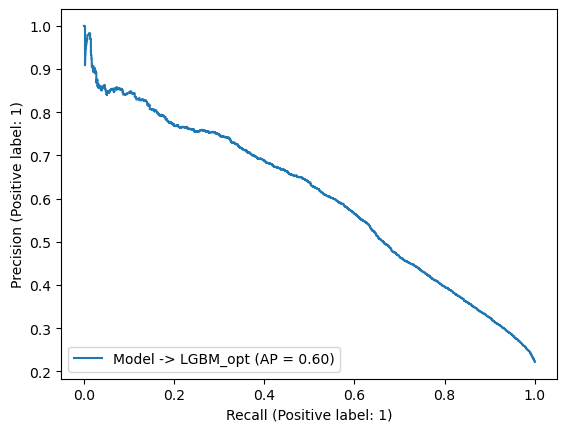

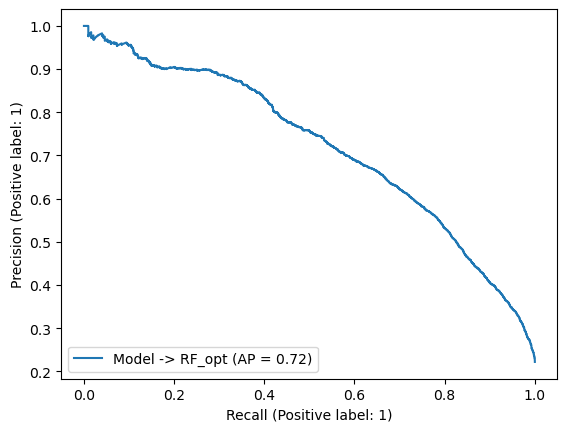

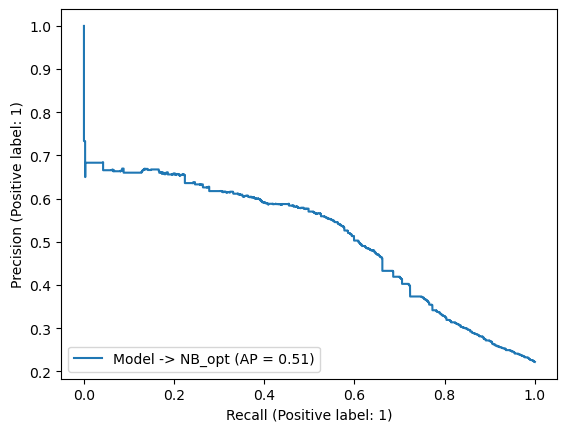

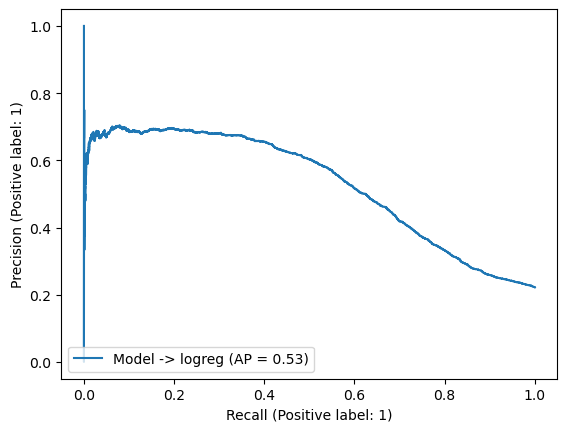

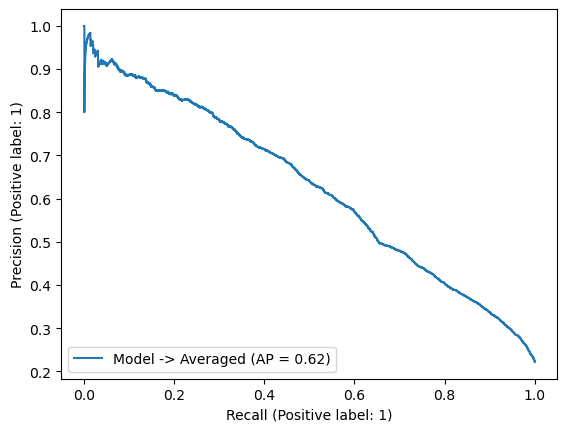

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay


# ConfusionMatrixDisplay.from_estimator(random_search_LGBM, X_train, y_train )

# ConfusionMatrixDisplay.from_estimator(random_search_RF, X_train, y_train)

# ConfusionMatrixDisplay.from_estimator(random_search_NB, X_train, y_train)

# ConfusionMatrixDisplay.from_estimator(random_search_logreg, X_train, y_train)


PrecisionRecallDisplay.from_estimator(random_search_LGBM, X_train, y_train,name = "Model -> LGBM_opt")

PrecisionRecallDisplay.from_estimator(random_search_RF, X_train, y_train,name = "Model -> RF_opt")

PrecisionRecallDisplay.from_estimator(random_search_NB, X_train, y_train,name = "Model -> NB_opt")

PrecisionRecallDisplay.from_estimator(random_search_logreg, X_train, y_train,name = "Model -> logreg")

PrecisionRecallDisplay.from_estimator(averaged_model, X_train, y_train,name = "Model -> Averaged")


In [73]:
combined_results_opt = pd.concat(
cross_val_results,
axis='columns'
).xs(
'mean',
axis='columns',
level=1
).style.format(
precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
col_list_opt
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM_bal,LGBM_bal_RFE,LGBM_opt,NB_bal,NB_bal_RFE,NB_opt,RF_bal,RF_bal_RFE,RF_opt,Voting_Classifier,dummy,logreg,logreg_RFE
fit_time,0.136,2.082,2.210,0.024,2.121,1.921,3.101,3.328,4.805,134.076,0.003,0.052,1.874
score_time,0.010,0.019,0.016,0.010,0.011,0.010,0.065,0.070,0.061,0.072,0.005,0.009,0.010
test_accuracy,0.778,0.773,0.774,0.788,0.794,0.794,0.821,0.792,0.794,0.784,0.778,0.760,0.758
train_accuracy,0.844,0.809,0.779,0.787,0.794,0.794,1.000,0.998,0.834,0.791,0.778,0.760,0.758
test_precision,0.499,0.491,0.493,0.519,0.535,0.535,0.668,0.564,0.533,0.511,0.000,0.470,0.468
train_precision,0.615,0.554,0.502,0.519,0.534,0.534,1.000,0.992,0.614,0.524,0.000,0.471,0.467
test_recall,0.624,0.633,0.636,0.583,0.564,0.565,0.381,0.399,0.586,0.622,0.000,0.651,0.651
train_recall,0.798,0.723,0.651,0.583,0.559,0.559,1.000,0.998,0.684,0.636,0.000,0.653,0.653
test_f1,0.555,0.553,0.555,0.549,0.548,0.549,0.485,0.462,0.558,0.561,0.000,0.546,0.544
train_f1,0.695,0.627,0.567,0.549,0.546,0.546,1.000,0.995,0.647,0.574,0.000,0.547,0.545


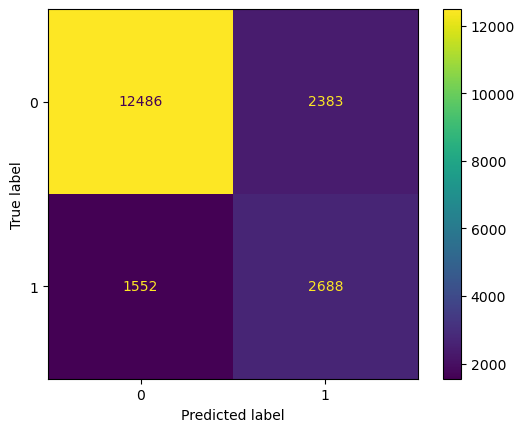

In [74]:
ConfusionMatrixDisplay.from_estimator(averaged_model, X_train, y_train )


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 11. Interpretation and feature importances <a name="1"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 
    
</div>

_Points:_ 8

Based on eli5 and permutation importance, we can see that `PAY_0` and `total_pay` are extremely significant in the LGBM model. This makes reasonable sense, as an individual's behavior in the first pay period (`PAY_0`) is probably a good indicator of their overall payment habits, and our engineered feature `total_pay` provides an overall summary of the individuals pay habits. 

Interestingly, the amount of money paid/ owing does not seem as significant as the behavioral pay habits of the individual, possibly because large spenders may be more likely to have large incomes, and be able to pay off large bill amounts. 

Another interesting point is that Shap highlights `LIMIT_BAL` as the most important feature, which is considered only moderately important in eli5 and permutation. Importance of this feature does make logical sense as individuals with high credit limits are more likely to run themselves into an irrecoverable position and be forced to default, but it is interesting that this importance is reflected primarily in SHAP, but not in eli5 and permutation.

In [ ]:
import eli5

eli5.explain_weights(random_search_LGBM.best_estimator_)

In [ ]:
from sklearn.inspection import permutation_importance

# adapted from "get_permutation_importance" function from 573 Lec 8
perm_imp = permutation_importance(random_search_LGBM.best_estimator_, X_train, y_train, n_repeats=10, random_state=123)
perm_imp_sorted = perm_imp.importances_mean.argsort()
plt.boxplot(
        perm_imp.importances[perm_imp_sorted].T,
        vert=False,
        labels=X_train.columns[perm_imp_sorted])
plt.xlabel('Permutation feature importance')
plt.show()


In [ ]:
X_train_transformed = pd.DataFrame(data =preprocessor.transform(X_train), columns = X_train.columns.tolist(), index=X_train.index)

In [ ]:
import shap
lgbm_shap = shap.TreeExplainer(random_search_LGBM.best_estimator_)
training_shap = lgbm_shap.shap_values(X_train_transformed)

shap.summary_plot(training_shap[1], X_train_transformed, plot_type = 'bar')



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 12. Results on the test set <a name="12"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  
    
</div>

_Points:_ 6

The f1 score on our test dataset is 57% which is very close to our train and validatio scores. So our model is performing well

In [90]:
from sklearn.metrics import f1_score

f1_score(y_test,averaged_model.predict(X_test))

0.5723905723905723

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 13. Summary of results <a name="13"></a>
rubric={reasoning}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook.
    
</div>

_Points:_ 8

_Type your answer here, replacing this text._

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 14. Creating a data analysis pipeline (Challenging)
rubric={reasoning}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. Submit your project folder in addition to this notebook on GitHub and briefly comment on your organization in the text box below.
    
</div>

_Points:_ 2

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 15. Your takeaway from the course (Challenging)
rubric={reasoning}

**Your tasks:**

What is your biggest takeaway from this course? 
    
</div>

_Points:_ 0.25

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<div class="alert alert-danger" style="color:black">
    
**Restart, run all and export a PDF before submitting**
    
Before submitting,
don't forget to run all cells in your notebook
to make sure there are no errors
and so that the TAs can see your plots on Gradescope.
You can do this by clicking the ▶▶ button
or going to `Kernel -> Restart Kernel and Run All Cells...` in the menu.
This is not only important for MDS,
but a good habit you should get into before ever committing a notebook to GitHub,
so that your collaborators can run it from top to bottom
without issues.
    
After running all the cells,
export a PDF of the notebook (preferably the WebPDF export)
and upload this PDF together with the ipynb file to Gradescope
(you can select two files when uploading to Gradescope)
</div>

---

## Help us improve the labs

The MDS program is continually looking to improve our courses, including lab questions and content. The following optional questions will not affect your grade in any way nor will they be used for anything other than program improvement:

1. Approximately how many hours did you spend working or thinking about this assignment (including lab time)?

#Ans:

2. Do you have any feedback on the lab you be willing to share? For example, any part or question that you particularly liked or disliked?

#Ans: